In [7]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings

import matplotlib as mpl
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import numpy as np
import imodels
from imodels.util.data_util import get_clean_dataset

sys.path.append('..')

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

from config.saps.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from viz import *

print('num_datasets', len(DATASETS_CLASSIFICATION), len(DATASETS_REGRESSION))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

num_datasets 11 9


In [8]:
X, y, feature_names = get_clean_dataset('iai_pecarn.csv', 'imodels')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
m = imodels.SaplingSumClassifier(max_rules=5)

In [10]:
sample_weight = np.ones_like(y_train)
sample_weight[y_train == 1] = 100
m.fit(X_train, y_train, feature_names=feature_names, sample_weight=sample_weight)

SaplingSumClassifier(max_rules=5)

In [11]:
print(m)

------------
AbdomenPain_no <= 0.500 (Tree #0 root)
	Val: 0.761 (leaf)
	GCSScore_Full_no <= 0.500 (split)
		DecrBreathSound_yes <= 0.500 (split)
			MOI_Fall down stairs <= 0.500 (split)
				LtCostalTender <= 1.500 (split)
					Val: 0.546 (leaf)
					Val: 0.133 (leaf)
				Val: 0.690 (leaf)
			Val: 0.791 (leaf)
		Val: 0.664 (leaf)



In [12]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        #         stats = sklearn.metrics.classification_report(y_test, preds,
        #                                                       output_dict=True,
        #                                                       zero_division=0)

        #         all_stats['sensitivity'].append(stats['1']['recall'])
        #         all_stats['specificity'].append(stats['0']['recall'])
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        plt.plot(all_stats['sens'], all_stats['spec'], '.-')
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds


preds = m.predict_proba(X_test)[:, 1]
# print(sklearn.metrics.classification_report(y_test, preds))

100%|██████████| 6/6 [00:00<00:00, 591.25it/s]


({'sens': [0.9242424242424242,
   0.9242424242424242,
   0.8787878787878788,
   0.8787878787878788,
   0.015151515151515152,
   0.0],
  'spec': [0.4746335963923337,
   0.49408117249154454,
   0.5338218714768884,
   0.5453776775648252,
   0.9937993235625705,
   1.0],
  'ppv': [0.03168831168831169,
   0.03286637931034483,
   0.03387850467289719,
   0.034709754637941355,
   0.043478260869565216,
   nan],
  'npv': [0.9970396684428656,
   0.997155858930603,
   0.9957939011566772,
   0.9958826556870818,
   0.9818991924255082,
   0.981737686773658],
  'lr+': [1.7592339706073612,
   1.8268591204524354,
   1.8850903228170461,
   1.9330064438557928,
   2.443526170798914,
   nan],
  'lr-': [0.1596127546246312,
   0.15333022178430059,
   0.22706473392851428,
   0.22225354318377574,
   0.9909933137386342,
   1.0],
  'f1': [0.06127574083375188,
   0.06347554630593132,
   0.06524184476940383,
   0.0667818077144502,
   0.02247191011235955,
   0.0]},
 [0.13262599469496023,
  0.546448087431694,
  0.6641

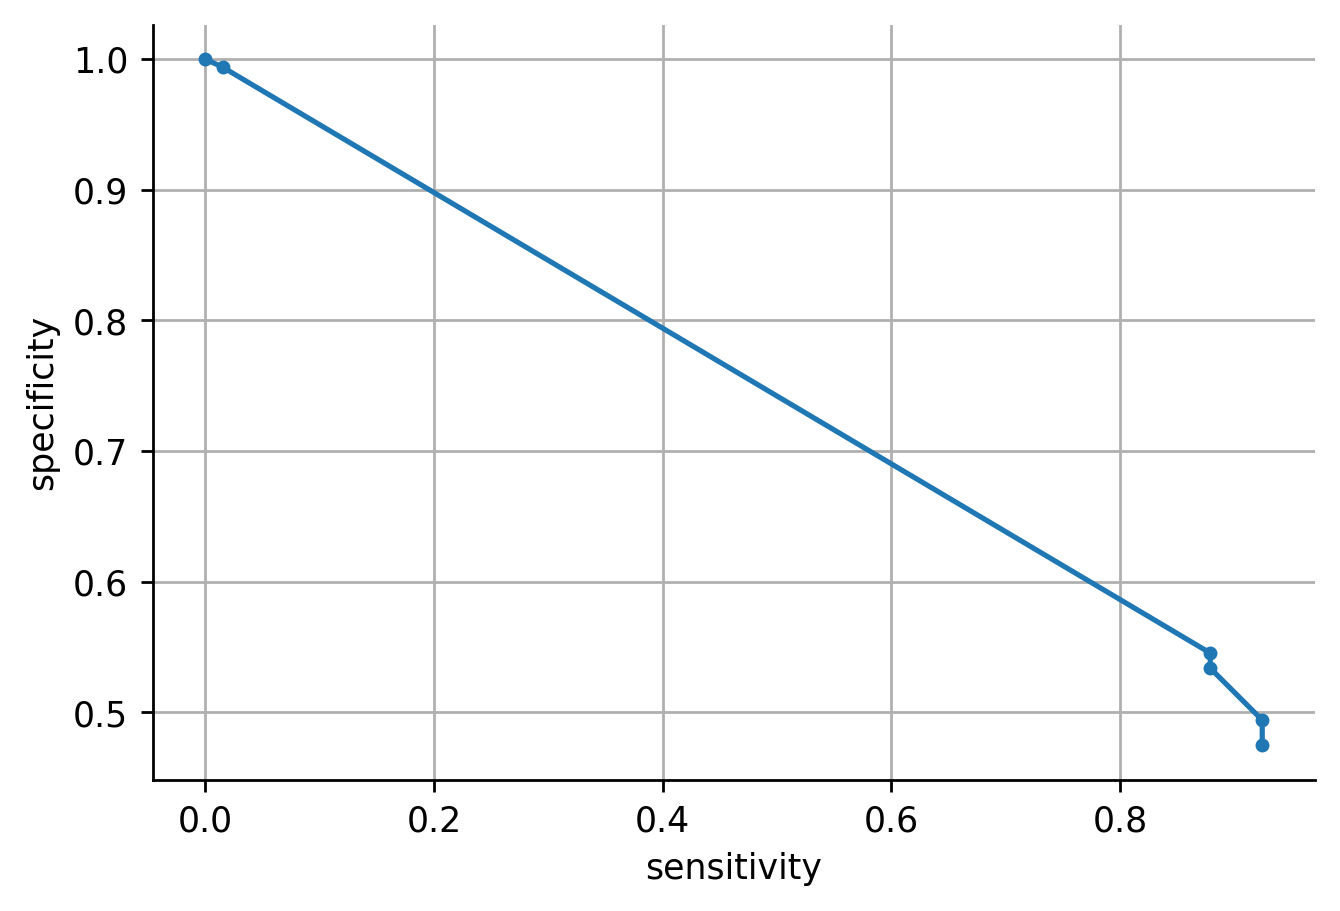

In [13]:
all_stats_curve(y_test, preds, plot=True)